# 0. Load  data and transform

In [17]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'

In [1]:
import pandas as pd
from scripts.load_data import load_data
folder_path = '/Users/CUDAN/Documents/GitHub/data_analysis_portfolio/data' #uni macbook
museums_data, museum_names = load_data(folder_path, filter_data=False)

/Users/CUDAN/Documents/GitHub/data_analysis_portfolio/scripts/load_data.py:18: DtypeWarning: Columns (5,7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)  # Read the CSV file into a DataFrame


In [13]:
collection_lag = []
for df in museums_data:
    # Calculate collection lag
    df['Collection_lag'] = pd.NA
    df['Year_acquisition'] = pd.to_numeric(df['Year_acquisition'], errors='coerce')
    df['Date_creation_year'] = pd.to_numeric(df['Date_creation_year'], errors='coerce')
    df['Collection_lag'] = df['Year_acquisition'] - df['Date_creation_year']
    
    # Group and count, specifying which column to count
    new_df = (df.groupby('Collection_lag')
              .size()  # Count occurrences
              .reset_index(name='count'))  # Reset index and name the count column
    
    collection_lag.append(new_df)

In [6]:
museums_data[0].columns

Index(['Artist', 'Title', 'Medium', 'Medium_classified',
       'Acquisition_classified', 'Year_acquisition', 'Gender_classified',
       'Artist_birth_year', 'Artist_death_year', 'Country_calculated',
       'Date_creation_year', 'Collection_lag'],
      dtype='object')

In [14]:
collection_lag[0].head()

,Collection_lag,count
0,-38.0,1
1,-16.0,1
2,-5.0,1
3,-4.0,1
4,-3.0,1


# 1. Plot collection lag distributions

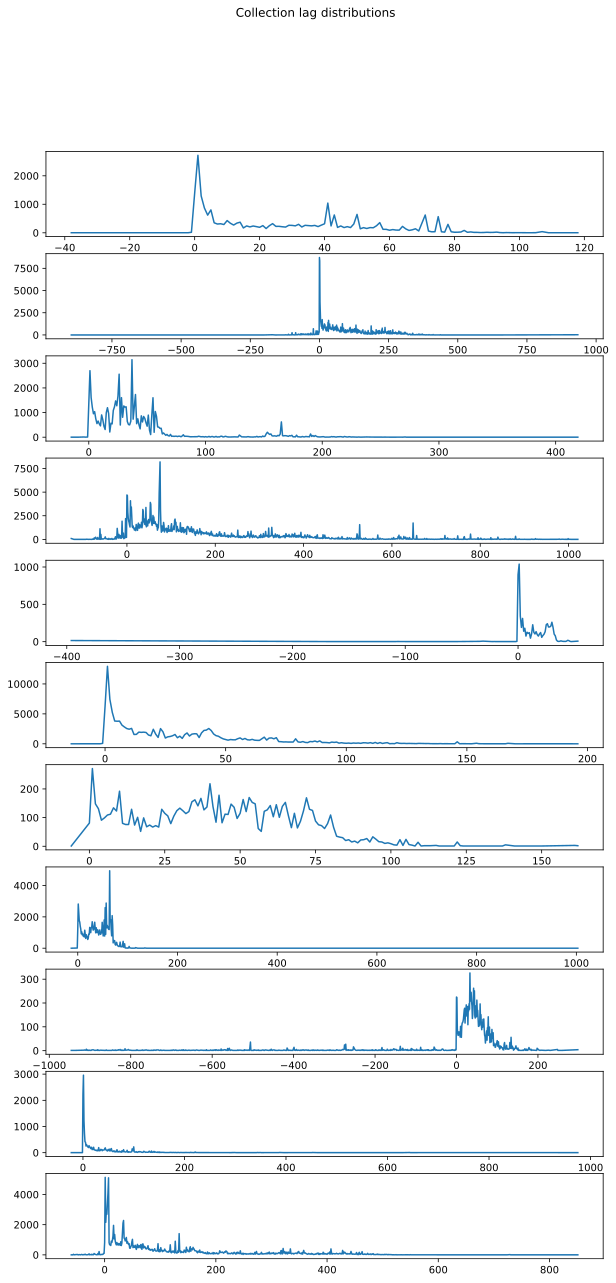

In [32]:
fig, axs = plt.subplots(nrows=11, ncols=1, figsize=(10, 20))
fig.suptitle('Collection lag distributions')
for i, df in enumerate(collection_lag):
    axs[i].plot(df['Collection_lag'], df['count'])

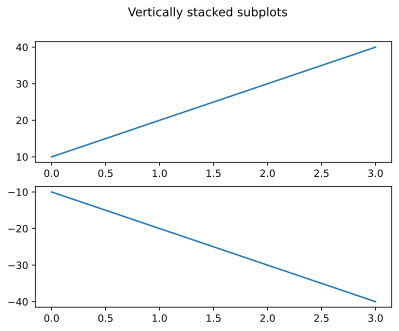

In [27]:
fig, axs = plt.subplots(2)
fig.suptitle('Vertically stacked subplots')
axs[0].plot(x, y)
axs[1].plot(x, -y)